In [1]:
import numpy as np
import svg
import time
import env
from PedestrianClass import Pedestrian
from euclid import Circle, Point2, Vector2, LineSegment2
from IPython.display import clear_output, display, HTML
import matplotlib.pyplot as plt

from env import num_pedestrains

crowd = []
xsize = 8
ysize = 8
amp = 80
offset = 30
ped_ra = 13
ped_buffersize = 0.5
ped_spdlimit = 1
ped_outcount = 0
ped_outflow = []
walls = [(Point2(0,0), Point2(xsize, 0)), 
         (Point2(0,0), Point2(0, ysize)), 
         (Point2(xsize/2, ysize/2), Point2(xsize, ysize/2)), 
         (Point2(xsize/2, ysize/2), Point2(xsize/2, ysize))
        ]

pos_rx = 1
pos_ry = 2

num_flowA = 150
num_flowB = 150


def build_scene():
    scene = svg.Scene((xsize*amp + 2*offset, ysize*amp + 2*offset + 40))
    # draw walls
    for wall in walls:
        p1 = wall[0] * amp + Point2(offset, offset)
        p2 = wall[1] * amp + Point2(offset, offset)
        scene.add(svg.Line(p1, p2))
    scene.add(svg.Rectangle(Point2(offset, offset), Point2(xsize*amp, ysize*amp)))
    return scene
    
def add_ped(num1, num2):
    for i in range(num1):
        rand = np.random.random([3])
        posX = rand[0] * 3 +1
        posY = -rand[1] * ped_buffersize
        #VelX = rand[2]
        ped = Pedestrian(np.array([posX]), np.array([posY]), c='blue')
        crowd.append(ped)
        
    for i in range(num2):
        rand = np.random.random([3])
        posX = -rand[0] * ped_buffersize
        posY = rand[1] * 2 + 5
        ped = Pedestrian(np.array([posX]), np.array([posY]), c='red')
        crowd.append(ped)
        
def move_crowd(robot_flag):
    # check, remove and add
    global ped_outcount, ped_outflow
    to_remove = []
    numblue = 0
    numred = 0
    for ped in crowd:
        if ped.x > xsize:
            to_remove.append(ped)
            if ped.c == 'blue':
                numblue += 1
            else:
                numred += 1
    ped_outcount += numblue + numred
    if step % 10 ==0:
        ped_outflow.append(ped_outcount)
        ped_outcount = 0

    if to_remove is not None:
        for ped in to_remove:
            crowd.remove(ped)
        add_ped(numblue, numred)
            
    posX=[]
    posY=[]
    velX=[]
    velY=[]
    
    for ped in crowd:
        posX.append(ped.x)
        posY.append(ped.y)
        # speed limit
        spd = np.sqrt(ped.vx**2 + ped.vy**2)
        if spd > ped_spdlimit:
            ped.vx = (ped_spdlimit/spd)*ped.vx
            ped.vy = (ped_spdlimit/spd)*ped.vy
        velX.append(ped.vx)
        velY.append(ped.vy)
    pos_x = np.reshape(posX, [-1,1])
    pos_y = np.reshape(posY, [-1,1])
    vel_x = np.reshape(velX, [-1,1])
    vel_y = np.reshape(velY, [-1,1])
    
    #print posX, posY
    

    
    f_hhi_matrix_x, f_hhi_matrix_y = env.human_human_force(pos_x, pos_y)    
    f_hhi_x = np.expand_dims( np.sum(f_hhi_matrix_x, axis=0), 1)
    f_hhi_y = np.expand_dims( np.sum(f_hhi_matrix_y, axis=0), 1)
    
    f_hwi_x, f_hwi_y = env.human_wall_force(pos_x, pos_y)
    f_sd_x, f_sd_y = env.self_driven_force(pos_x, pos_y, vel_x, vel_y)
    if robot_flag:
        f_hri_x, f_hri_y = env.human_robot_force(pos_x, pos_y, pos_rx, pos_ry)
        f_comb_x = f_sd_x + f_hwi_x + f_hhi_x + f_hri_x
        f_comb_y = f_sd_y + f_hwi_y + f_hhi_y + f_hri_y        
    else:
        f_comb_x = f_sd_x + f_hwi_x + f_hhi_x
        f_comb_y = f_sd_y + f_hwi_y + f_hhi_y
    
    for i, ped in enumerate(crowd):
        m = 1
        ped.step(ax=f_comb_x[i]/m, ay=f_comb_y[i]/m)
        
def render_scene(scene):
    for ped in crowd:
        # axis transform
        o = Point2(ped.x*amp, (ysize-ped.y)*amp) + Point2(offset, offset)
        scene.add(svg.Circle(o, radius = ped_ra, color=ped.c))
    robot_o = Point2(pos_rx*amp, (ysize-pos_ry)*amp) + Point2(offset, offset)
    scene.add(svg.Circle(robot_o, radius = ped_ra, color='black'))
        
    # write text
#     text = 'Ped outflow  ' + str(ped_outflow)
#     scene.add(svg.Text((400,500), text, 20))
    clear_output(wait=True)
    display(scene)

/home/uri7910/anaconda2/envs/tensorflow011/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
crowd = []
add_ped(num_flowB, num_flowA)
numstep = 1000
for step in range(numstep):
    move_crowd(True)
    scene = build_scene()
    render_scene(scene)
    #time.sleep(0.01)
    #print step       
    

<svg.Scene instance at 0x7f2343fbfdd0>

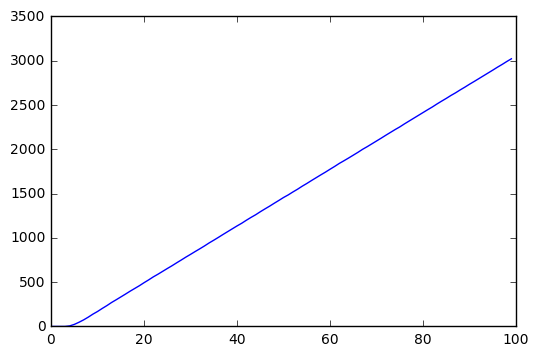

3022


In [3]:
accum_flow = []
for time_sec in range(len(ped_outflow)):
    accum_flow.append( sum(ped_outflow[:time_sec]) ) 
plt.plot(range(len(ped_outflow)), accum_flow)
plt.show()
ped_outflow = []
print accum_flow[-1]

In [4]:
crowd = []
add_ped(num_flowB, num_flowA)
numstep = 1000
for step in range(numstep):
    move_crowd(False)
    scene = build_scene()
    render_scene(scene)
    #time.sleep(0.01)
    #print step

<svg.Scene instance at 0x7f2343f55758>

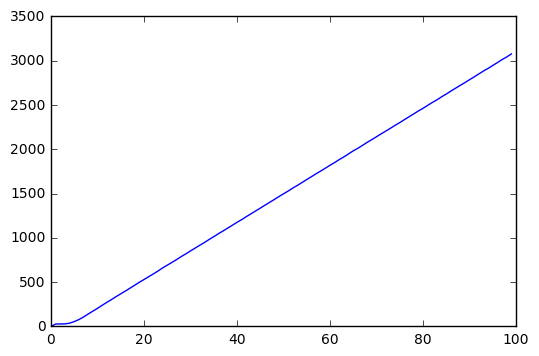

3077


In [5]:
accum_flow_2 = []
for time_sec in range(len(ped_outflow)):
    accum_flow_2.append( sum(ped_outflow[:time_sec]) ) 
plt.plot(range(len(ped_outflow)), accum_flow_2)
plt.show()
ped_outflow = []
print accum_flow_2[-1]